In [1]:
## Uncomment this if you are using Colab
#!git clone https://github.com/tprunarsson/HafrallX64.git
#import os
#os.chdir('/content/HafrallX64')
#!pip install gurobipy==11.0.3
# ## !touch __init__.py

In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import time
import argparse
from itertools import combinations
from utils import DistanceLink, readDat, writeDat, drawTour

In [3]:
(tSHIP,tSTAT,tWAYP,tENDP,tPORT) = (1,2,3,4,5)

def subtour_(vals):
    global n_global
    # make a list of edges selected in the solution
    edges = gp.tuplelist((i, j) for i, j in vals.keys()
                         if vals[i, j] > 0.5)
    n = n_global
    unvisited = list(range(n))
    cycle = list(range(n+1))  # initial length has 1 more city
    listlen = []
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if (len(cycle) >= len(thiscycle)):
            cycle = thiscycle
        listlen.append(len(thiscycle))
    print(n, listlen)
    return cycle

# Callback - use lazy constraints to eliminate sub-tours
def subtourelim_(model, where):
    global n_global
    n = n_global
    if where == GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(model._vars)
        # find the shortest cycle in the selected edge list
        tour = subtour_(vals)
        if len(tour) < n:
            # add subtour elimination constr. for every pair of cities in tour
            print("adding tour elimination ___ :", n, len(tour),tour)
            model.cbLazy(gp.quicksum(model._vars[i, j] + model._vars[j, i]
                                     for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Given a tuplelist of edges, find the shortest subtour
n_global = 0

def solveit_(dist, n, Amount, shipCap, Type, timelimit = 3600, useAmount = False, useSubtour = True):

    global n_global
    n_global = 2*n
    # put your API license key here
    options = options = {
        "WLSACCESSID": "",
        "WLSSECRET": "",
        "LICENSEID": 0,
        'TimeLimit': 60*3
        }
    m = gp.Model(env=gp.Env(params=options))
    n = 2*n

    #m.setParam('OutputFlag', 0)
    m.setParam("TimeLimit", timelimit)
    m.setParam('Threads', 4)

    n2 = int(n/2)

    distx = dist[:n,:n]
    distx[0,1] = 0
    distx[1,0] = 0 # close the loop for start and end, this distance should be zero of not counted!

    # Create variables
    N = [(i,j) for i in range(n) for j in range(n)]
    vars = m.addVars(N, obj=distx, vtype=GRB.BINARY, name='e')

    if useAmount:
        w = m.addVars(N, ub = shipCap, vtype=GRB.CONTINUOUS, name='w')
        N1 = [(2*i,2*i+1) for i in range(n2) if Type[i] != tPORT] + [(2*i+1,2*i) for i in range(n2) if Type[i] != tPORT]
        v = m.addVars(N1, ub = shipCap, vtype=GRB.CONTINUOUS, name='v')

    # Add degree-2 constraint
    m.addConstrs(gp.quicksum(vars[i,j] for j in range(n) if (i,j) in N) == 1 for i in range(n))
    m.addConstrs(gp.quicksum(vars[j,i] for j in range(n) if (j,i) in N) == 1 for i in range(n))
    #m.addConstrs(vars[i,j] + vars[j,i] <= 1 for (i,j) in N) # this is probably not necessary!

    m.addConstrs(vars[2*i,2*i+1]+vars[2*i+1,2*i] == 1 for i in range(int(n/2)))
    m.addConstrs(vars[i,i] == 0 for i in range(n))

    # the flow into
    if useAmount:
        m.addConstrs(gp.quicksum(w[k,2*j] for k in range(n) if k != (2*j+1)) + v[2*j,2*j+1] ==
                 w[2*j,2*j+1] for j in range(n2) if Type[j] != tPORT)

        m.addConstrs(gp.quicksum(w[k,2*j+1] for k in range(n) if k != (2*j)) + v[2*j+1,2*j] ==
                 w[2*j+1,2*j] for j in range(n2) if Type[j] != tPORT )

        m.addConstrs(v[2*j,2*j+1]+v[2*j+1,2*j] == Amount[j] for j in range(n2) if Type[j] != tPORT)

        m.addConstrs(w[2*j,2*j+1] == gp.quicksum(w[2*j+1,k] for k in range(n) if k != 2*j and k != (2*j+1)) for j in range(n2) if Type[j] != tPORT)
        m.addConstrs(w[2*j+1,2*j] == gp.quicksum(w[2*j,k] for k in range(n) if k != (2*j+1) and k != 2*j) for j in range(n2) if Type[j] != tPORT)

    # I have carefully forced zeros to make the equations above with fewer conditions!
        m.addConstrs(w[i,j] <= shipCap*vars[i,j] for (i,j) in N) # only fish where there is a connection
        # not sure what this one does, probablu not needed:
        m.addConstrs(v[i,j] <= shipCap*vars[i,j] for (i,j) in N1) # only fish where there is a connection
        m.addConstrs(w[i,j] == 0 for (i,j) in N if Type[int(i/2)] == tPORT) # all flow from port is zero

    # Optimize model
    if useSubtour:
        m._vars = vars
        m.Params.LazyConstraints = 1
        m.optimize(subtourelim_)
    else:
        m.optimize()

    vals = m.getAttr('X', vars)

    tour = subtour_(vals)
    #assert len(tour) == n

    W = np.zeros((n,n))
    V = np.zeros((n,n))
    X = np.zeros((n,n))
    # extract the fish flow
    for i in range(n):
        for j in range(n):
            if (i != j):
                X[i,j] = vars[i,j].X
                if useAmount:
                    W[i,j] = w[i,j].X
                    if (i,j) in N1:
                        V[i,j] = v[i,j].X

    tour = np.array(tour)

    letour = []
    for i in range(n):
        if int(tour[i]/2) not in letour and -int(tour[i]/2) not in letour:
            if tour[i] % 2 == 1:
                letour.append(-int(tour[i]/2))
            else:
                letour.append(int(tour[i]/2))
    letour = np.array(letour)
    letour = np.concatenate((letour[np.where(letour==0)[0][0]:],letour[:np.where(letour==0)[0][0]]))
    if Type[abs(letour[1])] == tPORT:
        letour[1:] = -letour[:0:-1]
    letour[Type[np.abs(letour)]==tPORT] = np.abs(letour[Type[np.abs(letour)]==tPORT])
    print('Optimal tour: %s' % str(letour))
    print('Optimal cost: %g' % m.ObjVal)
    return m.ObjVal, letour, W, V, X

def runit(file, ship_id, name, run, mode, ShipCap, TimeWindow = None):
    (tSHIP,tSTAT,tWAYP,tENDP,tPORT) = (1,2,3,4,5)
    ship_names = ["Árni Friðriksson","Bjarni Sæmundsson","Gullver","Breki"]
    ship = ship_names[ship_id-1]
    print(ship)
    (Tour, Type, Amount, Fixed, LatLonRad, Name, Rotated, ShipCap_, ExtraTime) = readDat(file, ship)
    if ShipCap == None:
        ShipCap = ShipCap_
# Extract the available ports
    TypePort = list(set([Name[i] for i in range(len(Type)) if Type[i] == tPORT]))
    TypePort = {type: len([Name[i] for i in range(len(Type)) if Name[i] == type]) for type in TypePort}
# Extract the vailable waypoints
    TypeWayp = list(set([Name[i] for i in range(len(Type)) if Type[i] == tWAYP]))
    TypeWayp = {type: len([Name[i] for i in range(len(Type)) if Name[i] == type]) for type in TypeWayp}
# Stack on the bottom the waypoints and top the ship, should only be one ship
    ExLatLonRad = np.vstack((LatLonRad[Type == tSHIP,:], LatLonRad[Type == tSTAT,:], LatLonRad[Type == tPORT,:] ,LatLonRad[Type == tWAYP,:]))
    ExType = np.concatenate((Type[Type == tSHIP],Type[Type == tSTAT],Type[Type == tPORT],Type[Type == tWAYP]))
    ExAmount = np.concatenate((Amount[Type == tSHIP],Amount[Type == tSTAT],Amount[Type == tPORT],Amount[Type == tWAYP]))
    print(ExtraTime)
    ExExtraTime = np.concatenate((ExtraTime[Type == tSHIP],ExtraTime[Type == tSTAT],ExtraTime[Type == tPORT],ExtraTime[Type == tWAYP]))
    ExFixed = np.concatenate((Fixed[Type == tSHIP],Fixed[Type == tSTAT],Fixed[Type == tPORT],Fixed[Type == tWAYP]))
    Name = np.array(Name)
    ExName = np.concatenate((Name[Type == tSHIP],Name[Type == tSTAT],Name[Type == tPORT],Name[Type == tWAYP]))
    ExRotated = np.concatenate((Rotated[Type == tSHIP],Rotated[Type == tSTAT],Rotated[Type == tPORT],Rotated[Type == tWAYP]))
    SelectedSize = ExLatLonRad.shape[0]
    Size = np.sum(ExType == tSTAT) + np.sum(ExType == tPORT) + np.sum(ExType == tSHIP)
    print("SelectedSize", SelectedSize, "Size", Size, "ExType=", ExType, "tSHIP=", tSHIP)
    StartEnd = ExLatLonRad[ExType == tSHIP,:][0]
    print("StartEnd=", StartEnd)
    print("ShipCap=", ShipCap)
    Elite = np.zeros(Size)
    print(ExName)
    # Place the code you want to time here
    (DistMtrx, FsbleMtrx) = DistanceLink(ExType, ExLatLonRad, StartEnd, Size, SelectedSize)
    start_time = time.time()
    if mode == "gurobi":
        (obj, e, W, V, X) = solveit_(DistMtrx, Size, ExAmount, ShipCap, ExType, timelimit = 3600)
    else:
        print("mode is unknown!")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time} seconds")
    drawTour(e, ExLatLonRad, ExType, ExAmount, DistMtrx, FsbleMtrx)
    print(obj,e)
    writeDat('output_'+mode+'_'+ship[:4]+'_'+str(int(ShipCap))+'_'+name+'_'+str(run)+'.dat', e, mode, ExType, ExAmount, ExFixed, ExLatLonRad, ExName, ExtraTime, ship)


Bjarni Sæmundsson
reading file:  data/data2023spring.dat
the number of line is: 641 searching for "Bjarni Sæmundsson"
found ship "Bjarni Sæmundsson" at line 0
[ 0 12 14 15 15 14 13 16 19 19 16 20 20 24 22 23 27 32 24 29 36 29 28 27
 28 23 26 13 27 16 25 18 23 24 31 31 30  0 23 20 26 34 25 20 17 41 20 21
 25 26 19 13 17 12 18 20  0 14 16 19 19 13 17 21 16 26 24 19 38 22 14 18
 21 16 15 14 14 18 21 21 17 17 21 15 16 14 14 12 10 18 20 13 14 18 20 31
 20 14 20  0 10 10  9  9 11 11 10 16 21 21 24 12 15 18 24  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
SelectedSize 143 Size 116 ExType= [1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3] tSHIP= 1
StartEnd= [1.16175224 0.3959803  0.         0.        ]
ShipCap= 14000.

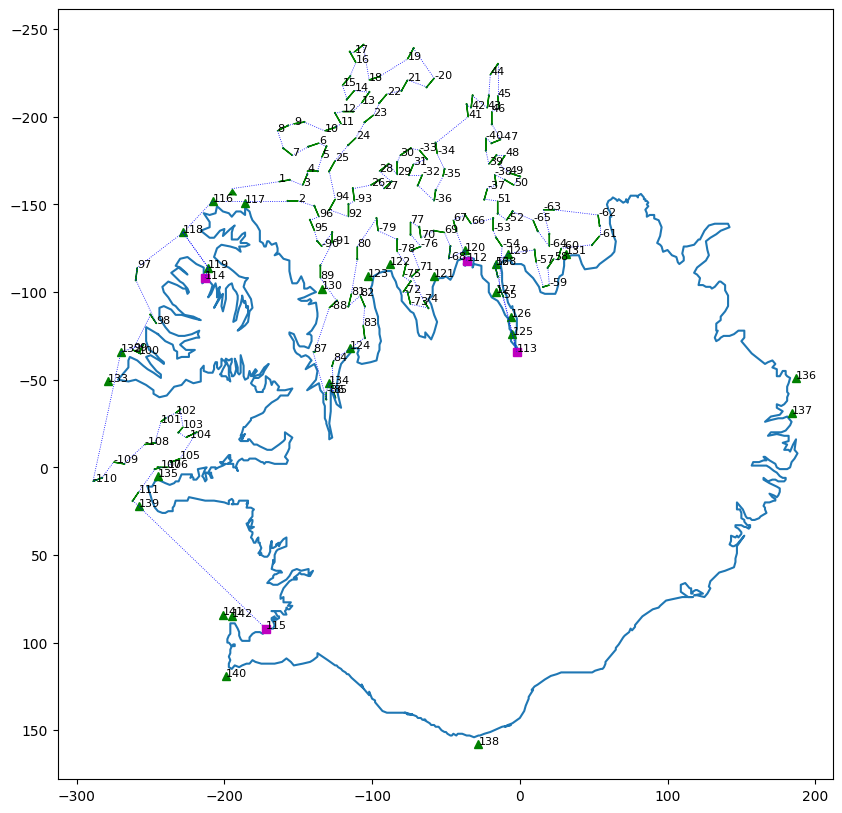

5024.057721958798 [   0    1    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19  -20   21   22   23   24   25   94   92  -93
   26   27   28   29   30  -33   31  -32  -36  -35  -34   41   42   43
   44   45   46  -47  -40   39   48   49   50  -38  -37   51  -52  -65
  -64  -63  -62  -61  -60   58  -59  -57   56  113   55  -54  -53   66
   67  112  -68   69   70   77  -76   71   74  -73  -72  -75  -78  -79
   80   81   82   83   84   85  -86   87  -88   89  -91  -90   95   96
    2  114   97   98   99  100 -110 -109 -108  101  102  103 -104  105
  106  107  111  115]
BOAT 1 0 [   0    1    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19  -20   21   22   23   24   25   94   92  -93
   26   27   28   29   30  -33   31  -32  -36  -35  -34   41   42   43
   44   45   46  -47  -40   39   48   49   50  -38  -37   51  -52  -65
  -64  -63  -62  -61  -60   58  -59  -57   56  113   55  -54  -53   66
   67  112  -68   69   70   

In [4]:
# Main
file, ship, name, run, mode, capacity = "data/data2023spring.dat", 2, 'tmp', 0, 'gurobi', None
runit(file, ship, name, run, mode, capacity)